<a href="https://colab.research.google.com/github/xharles2994/Tensorflow_models/blob/main/Retrieval_Model_For_Games_recommendation_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Retrieval_Model_For_Games_recommendation_CV.ipynb

##problem Statement:
The Steam Store, a popular digital distribution platform for video games, provides users with a vast selection of games to choose from. However, with such a large number of games available, it becomes challenging for users to discover games that align with their preferences and interests. The existing recommendation system on the Steam Store lacks the ability to effectively combine retrieval and ranking techniques to provide personalized game recommendations. Therefore, there is a need to develop a combined retrieval and ranking system for game recommendations on the Steam Store using a two-tower model with TensorFlow Recommenders.

##Objective:
The objective of this project is to design and implement a game recommendation system for the Steam Store that leverages the power of TensorFlow Recommenders and utilizes a two-tower model. The system should address the limitations of the existing recommendation system and provide users with personalized and relevant game recommendations based on their preferences. The specific objectives of the project are as follows:

1. Data Preparation: Collect and preprocess the relevant data, including user preferences, game metadata, and historical interactions, to create a suitable dataset for training and evaluation.

2. Model Development: Build a combined retrieval and ranking model using a two-tower architecture with TensorFlow Recommenders. The two-tower model should incorporate both user preferences and game features to generate personalized recommendations.

3. Training and Evaluation: Train the two-tower model using the prepared dataset and evaluate its performance using appropriate evaluation metrics. Fine-tune the model to optimize recommendation accuracy and relevance.

4. Integration with Steam Store: Integrate the developed recommendation system with the Steam Store platform, enabling users to receive personalized game recommendations based on their preferences.

5. User Interface: Design and develop a user-friendly interface that allows users to provide feedback on recommended games, explore additional recommendations, and customize their preferences.

6. Performance Optimization: Optimize the recommendation system for scalability and efficiency to handle a large number of users and games, ensuring real-time recommendations with minimal latency.

By achieving these objectives, the combined retrieval and ranking system utilizing a two-tower model will enhance the game discovery experience on the Steam Store, providing users with tailored recommendations that match their interests and preferences.

###Imports
Let's include our imports here. Here we import our tensorflow and python libaries to be called in the project

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 17.1 MB/s eta 0:00:00


In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import tensorflow_recommenders as tfrs

#About the dataset
https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

##Context
The dataset contains cleaned and preprocessed 10M+ samples of user recommendations (reviews) from a Steam Store - a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content. Additionally, it contains detailed information about games and add-ons.
The dataset consists of three main entities:

##Content
Games.csv - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;

Users.csv - a table of user profiles' public information: the number of purchased products and reviews published;

Recommendations.csv - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.



#Acknowledgement - The dataset was collected from Steam Official Store. All rights on the dataset thumbnail image belong to the Valve Corporation.

#Preparing the dataset
Let's first have a look at the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# load the recommenders data

columns = ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'user_id', 'review_id']
ratings = pd.read_csv('/content/drive/MyDrive/PORTFOLIO/Dataset/Game-recommendation_Retrieval/recommendations.csv')
ratings.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,19954,0
1,304390,4,0,2017-02-17,False,11.5,1098,1
2,1085660,2,0,2019-11-17,True,336.5,91207,2
3,703080,0,0,2022-09-23,True,27.4,93054,3
4,526870,0,0,2021-01-10,True,7.9,9106,4


In [ ]:
# load the games data

columns = ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio',
          'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']

games = pd.read_csv('/content/drive/MyDrive/PORTFOLIO/Dataset/Game-recommendation_Retrieval/games.csv')
games = games[['app_id', 'title']]
games.head()

,app_id,title
0,10090,Call of Duty: World at War
1,13500,Prince of Persia: Warrior Within™
2,22364,BRINK: Agents of Change
3,113020,Monaco: What's Yours Is Mine
4,226560,Escape Dead Island


In [ ]:
# join the ratings with the games

ratings = pd.merge(ratings, games, on='app_id')


# keep only the user id and the games title columns

ratings = ratings[['title', 'user_id']].reset_index(drop=True)

ratings

,title,user_id
0,Dwarf Fortress,19954
1,Dwarf Fortress,4993590
2,Dwarf Fortress,4452487
3,Dwarf Fortress,3602361
4,Dwarf Fortress,5279412
...,...,...
10072265,Paragon: The Overprime,373561
10072266,Paragon: The Overprime,2165144
10072267,Paragon: The Overprime,4388597
10072268,Paragon: The Overprime,705328


In [ ]:
# save to a csv file

ratings.to_csv('ratings.csv', index=False)
games.to_csv('games.csv', index=False)

In [ ]:
from typing import Dict, Text
# read the csv files as pandas data frames
ratings_df = pd.read_csv('ratings.csv')
games_df = pd.read_csv('games.csv')


We now convert our Panda Dataframe into Tensorflow dataset

In [ ]:
# convert them to tf datasets
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
games = tf.data.Dataset.from_tensor_slices(dict(games_df))

In [ ]:
# get the first rows of the games dataset in tensorflows records
for g in games.take(5):
  print(g)

{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=10090>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Call of Duty: World at War'>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=13500>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Prince of Persia: Warrior Within\xe2\x84\xa2'>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=22364>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'BRINK: Agents of Change'>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=113020>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b"Monaco: What's Yours Is Mine">}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=226560>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Escape Dead Island'>}


In [ ]:
# get the first rows of the ratings/recommendatons dataset in tensorflows records
for r in ratings.take(5):
  print(r)

{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19954>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=4993590>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=4452487>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=3602361>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=5279412>}


In this example, we're going to focus on the ratings data. Other tutorials explore how to use the game information data as well to improve the model quality.

We keep only the `user_id`, and `title` fields in the dataset.

In [ ]:
#We keep only the basic features i.e user_id, and title fields in the dataset.
ratings = ratings.map(lambda x: {
    "title": x["title"],
    "user_id": x["user_id"],
})
games = games.map(lambda x: x["title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


To fit and evaluate the model, we need to split it into a training and evaluation set.


In this simple example, however, let's use a random split, putting 80% of the ratings in the train set, and 20% in the test set.

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Let's also figure out unique user ids and game titles present in the data.

This is important because we need to be able to map the raw values of our categorical features to embedding vectors in our models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [ ]:
titles = games.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_game_titles = np.unique(np.concatenate(list(titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_game_titles[:10]

array([b'! That Bastard Is Trying To Steal Our Gold !',
       b'! Wild Russia !', b'!AnyWay!', b'!LABrpgUP!', b'#AkiRobots',
       b'#Archery', b'#CuteSnake', b'#CuteSnake 2', b'#Funtime',
       b'#KILLALLZOMBIES'], dtype=object)

## Implementing a model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

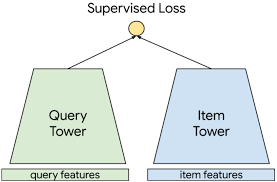

### The query tower

Let's start with the query tower.

The first step is to decide on the dimensionality of the query and candidate representations:

In [ ]:
embedding_dimension = 32

In [ ]:
user_model = tf.keras.Sequential([
  tf.keras.layers.IntegerLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

### The candidate/Item tower

We can do the same with the candidate tower.

In [ ]:
game_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_game_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_game_titles) + 1, embedding_dimension)
])

### Metrics

In our training data we have positive (user, game) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the `tfrs.metrics.FactorizedTopK` metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the `games` dataset, converted into embeddings via our game model:

In [ ]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=games.batch(128).map(game_model)
)

### Loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation:

In [ ]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.

The full model
We can now put it all together into a model. TFRS exposes a base model class (tfrs.models.Model) which streamlines building models: all we need to do is to set up the components in the __init__ method, and implement the compute_loss method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [ ]:
class GamesPreModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.game_model: tf.keras.Model = game_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_game_embeddings = self.game_model(features["title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_game_embeddings)

The `tfrs.Model` base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [ ]:
model = GamesPreModel(user_model, game_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
#Then shuffle, batch, and cache the training and evaluation data.
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
#Train the Model
model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 491s 46s/step - factorized_top_k/top_1_categorical_accuracy: 0.0606 - factorized_top_k/top_5_categorical_accuracy: 0.1466 - factorized_top_k/top_10_categorical_accuracy: 0.1588 - factorized_top_k/top_50_categorical_accuracy: 0.1868 - factorized_top_k/top_100_categorical_accuracy: 0.2013 - loss: 70369.3636 - regularization_loss: 0.0000e+00 - total_loss: 70369.3636
Epoch 2/3
10/10 [==============================] - 441s 44s/step - factorized_top_k/top_1_categorical_accuracy: 0.1041 - factorized_top_k/top_5_categorical_accuracy: 0.8819 - factorized_top_k/top_10_categorical_accuracy: 0.8854 - factorized_top_k/top_50_categorical_accuracy: 0.8926 - factorized_top_k/top_100_categorical_accuracy: 0.8958 - loss: 68915.2812 - regularization_loss: 0.0000e+00 - total_loss: 68915.2812
Epoch 3/3
10/10 [==============================] - 445s 44s/step - factorized_top_k/top_1_categorical_accuracy: 0.1345 - factorized_top_k/top_5_categorical_accuracy: 

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

Note that, in this example, we evaluate the metrics during training as well as evaluation. Because this can be quite slow with large candidate sets, it may be prudent to turn metric calculation off in training, and only run it in evaluation.

In [ ]:
#Evaluate model on testset
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 116s 23s/step - factorized_top_k/top_1_categorical_accuracy: 0.1294 - factorized_top_k/top_5_categorical_accuracy: 0.4364 - factorized_top_k/top_10_categorical_accuracy: 0.4399 - factorized_top_k/top_50_categorical_accuracy: 0.4476 - factorized_top_k/top_100_categorical_accuracy: 0.4514 - loss: 32698.9382 - regularization_loss: 0.0000e+00 - total_loss: 32698.9382


{'factorized_top_k/top_1_categorical_accuracy': 0.1294499933719635,
 'factorized_top_k/top_5_categorical_accuracy': 0.43639999628067017,
 'factorized_top_k/top_10_categorical_accuracy': 0.43985000252723694,
 'factorized_top_k/top_50_categorical_accuracy': 0.4476499855518341,
 'factorized_top_k/top_100_categorical_accuracy': 0.45135000348091125,
 'loss': 29723.67578125,
 'regularization_loss': 0,
 'total_loss': 29723.67578125}

## Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [ ]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    games.batch(100).map(lambda title: (title, model.game_model(title))))

# Get some recommendations.
_, titles = index(np.array([16]))
print(f"Top 10 recommendations for user 42: {titles[0, :10]}")

Top 10 recommendations for user 42: [b'Destiny 2' b'Legends of Ethernal' b'Darkwood - Soundtrack' b'Antenna'
 b'Outer Wilds - Original Soundtrack' b'Until You Fall' b'Cycle 28'
 b'Mirror Shoot' b'Turnip Boy Commits Tax Evasion'
 b'Victorian Mysteries: Woman in White']


Of course, the `BruteForce` layer is going to be too slow to serve a model with many possible candidates. The following sections shows how to speed this up by using an approximate retrieval index.

### Model serving
After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

a serving query model, taking in features of the query and transforming them into a query embedding, and
a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top games for that user. This is done via exporting the model to a `SavedModel` format, which makes it possible to serve using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

To deploy a model like this, we simply export the `BruteForce` layer we created above:

In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["10980"])

  print(f"Recommendations: {titles[0][:3]}")